Fitness evaluation
========

In [1]:
import numpy as np
import pandas as pd
import glob
import os.path
import sys

%matplotlib inline
import matplotlib.pyplot as plt
from plotting.plots import plotFitness

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from metric_learn import LMNN, NCA, LFDA, Covariance, MetricEvolution, NeuralNetworkTransformer, FullMatrixTransformer
from metric_learn import ITML_Supervised, SDML_Supervised, LSML_Supervised, RCA_Supervised
ME = MetricEvolution

datasetsDirectory = 'datasets'
# resultsDirectory = 'datasets-results-dim-reduction'
# graphsDirectory = 'datasets-graphs-dim-reduction'

# if not os.path.exists(resultsDirectory):
#     os.makedirs(resultsDirectory)
    
# if not os.path.exists(graphsDirectory):
#     os.makedirs(graphsDirectory)

# np.set_printoptions(precision=7, suppress=True, threshold=np.nan)
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

In [2]:
import glob, os

datasets = []
for file in glob.glob("{}/*.csv".format(datasetsDirectory)):
    datasets.append(file)
datasets.sort()

# datasets.remove('datasets/soybean-large.csv')
# datasets/balance-scale.csv (625, 5)
# datasets/breast-cancer-wisconsin.csv (699, 10)
# datasets.remove('datasets/digits10.csv') # (1797, 65)
# datasets.remove('datasets/digits6.csv') # (1083, 65)
# datasets/ionosphere.csv (351, 35)
# datasets/iris.csv (150, 5)
# datasets.remove('datasets/mice-protein.csv') # (1080, 78)
# datasets/pima-indians-diabetes.csv (768, 9)
# datasets/sonar.csv (208, 61)
# datasets/soybean-large.csv (307, 36)
# datasets/wine.csv (178, 14)

# datasets = datasets[7:8]
# logging.info("Datasets: " + str(datasets))

for x in datasets:
    print(x, pd.read_csv(x, sep=',', skiprows=1, header=0).shape)

datasets/balance-scale.csv (625, 5)
datasets/breast-cancer-wisconsin.csv (699, 10)
datasets/digits10.csv (1797, 65)
datasets/digits6.csv (1083, 65)
datasets/ionosphere.csv (351, 35)
datasets/iris.csv (150, 5)
datasets/letters.csv (20000, 17)
datasets/mice-protein.csv (1080, 78)
datasets/mnist.csv (70000, 785)
datasets/ofaces.csv (400, 4097)
datasets/pima-indians-diabetes.csv (768, 9)
datasets/sonar.csv (208, 61)
datasets/soybean-large.csv (307, 36)
datasets/wine.csv (178, 14)


In [3]:
def evaluateAllIndividuals(individuals, X_train, y_train, X_test, y_test, dim=None, k=4):
    results = []
    for individual in individuals:
        tr = FullMatrixTransformer(n_components=dim)
        tr.fit(X_train, y_train, individual)
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(tr.transform(X_train), y_train)
        results.append(knn.score(tr.transform(X_test), y_test))
    return results

def selMax(individuals):
    best = individuals[0]
    for i in range(1, len(individuals)):
        if individuals[i].fitness>best.fitness:
            best = individual[i]
    return best

def selMin(individuals):
    best = individuals[0]
    for i in range(1, len(individuals)):
        if individuals[i].fitness<best.fitness:
            best = individuals[i]
    return best

starting dataset balance-scale (625, 4)


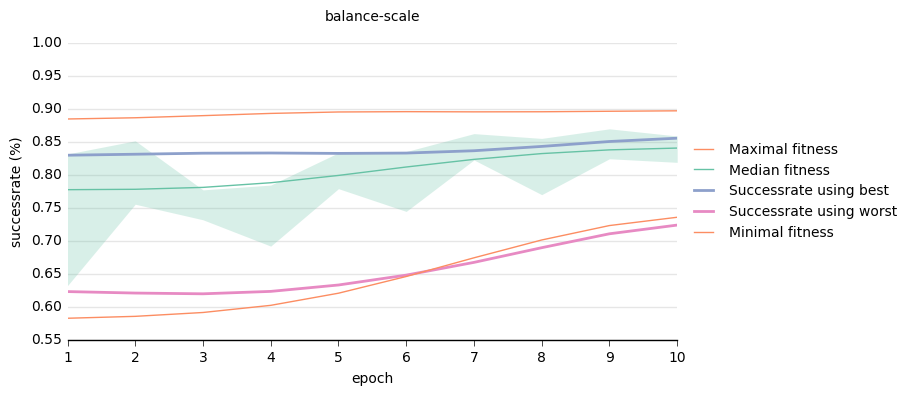

starting dataset breast-cancer-wisconsin (699, 9)


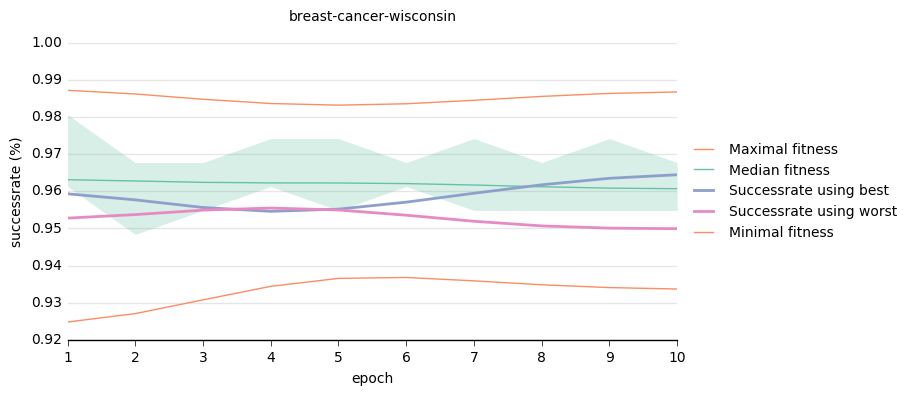

starting dataset digits10 (1797, 64)


KeyboardInterrupt: 

In [5]:
for filename in datasets:
    datasetName = filename[len(datasetsDirectory)+1:-4]
    data = pd.read_csv(filename, sep=',', skiprows=1, header=0)

    y = data['class']
    X = data.drop(['class'], axis=1).values
    
    print("starting dataset {} {}".format(datasetName, X.shape))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    le = LabelEncoder()
    y = le.fit_transform(y)

    imputer = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=False)
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    me = MetricEvolution(verbose=False, fitnesses=('knn',), s__n_gen=10, s__stats='identity')
    me.fit(X_train, y_train)
    
    logbook = me._strategy.logbook
    X = np.asarray([[ ind.fitness.wvalues for ind in x['id']] for x in logbook])
    X = np.squeeze(X, axis=2)

    individuals = np.asarray([selMax(x['id']) for x in logbook])
    worstindividuals = np.asarray([selMin(x['id']) for x in logbook])

    results = evaluateAllIndividuals(individuals, X_train, y_train, X_test, y_test)
    worstresults = evaluateAllIndividuals(worstindividuals, X_train, y_train, X_test, y_test)
    
    plotFitness(datasetName, X, results, worstresults, xlabel='epoch')
    plt.show()

#     break